# GPyOpt: configuring Scikit-learn methods

### Written by Javier Gonzalez and Zhenwen Dai, University of Sheffield.

Modified by Federico Tomasi, University of Genoa.

*Last updated Thursday, 28 September 2017.*

## Part I: Regression

The goal of this notebook is to use GPyOpt to tune the parameters of Machine Learning algorithms. In particular, in this section we will show how to tune the hyper-parameters for the [Support Vector Regression (SVR)](http://www.svms.org/regression/SmSc98.pdf) implemented in [Scikit-learn](http://scikit-learn.org/stable/). Given the standard interface of Scikit-learn, other models can be tuned in a similar fashion.

We start loading the requires modules.

In [ ]:
%pylab inline  
import GPy
import GPyOpt
import numpy as np
from sklearn import svm
from numpy.random import seed
seed(12345)

Populating the interactive namespace from numpy and matplotlib


For this example we will use the Olympic marathon dataset available in GPy. 
We split the original dataset into the training data (first 20 data points) and testing data (last 7 data points). The performance of SVR is evaluated in terms of Rooted Mean Squared Error (RMSE) on the testing data.

In [ ]:
# Let's load the dataset
GPy.util.datasets.authorize_download = lambda x: True # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_marathon_men()
X = data['X']
Y = data['Y']
X_train = X[:20]
Y_train = Y[:20,0]
X_test = X[20:]
Y_test = Y[20:,0]

Let's first see the results with the default kernel parameters.

In [ ]:
from sklearn import svm
svr = svm.SVR()
svr.fit(X_train,Y_train)
Y_train_pred = svr.predict(X_train)
Y_test_pred = svr.predict(X_test)
print("The default parameters obtained: C="+str(svr.C)+", epilson="+str(svr.epsilon)+", gamma="+str(svr.gamma))

We compute the RMSE on the testing data and plot the prediction. With the default parameters, SVR does not give an OK fit to the training data but completely miss out the testing data well.

RMSE = 0.56330740612


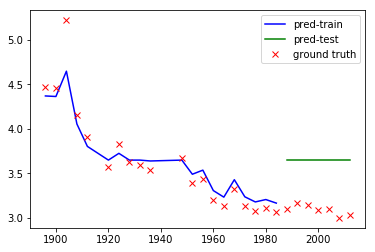

In [ ]:
plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')
plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')
print("RMSE = "+str(np.sqrt(np.square(Y_test_pred-Y_test).mean())))

Now let's try Bayesian Optimization. We first write a wrap function for fitting with SVR. The objective is the RMSE from cross-validation. We optimize the parameters in *log* space.

In [ ]:
nfold = 3
def fit_svr_val(x):
    x = np.atleast_2d(np.exp(x))
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        fs[i] = 0
        for n in range(nfold):
            idx = np.array(range(X_train.shape[0]))
            idx_valid = np.logical_and(idx>=X_train.shape[0]/nfold*n, idx<X_train.shape[0]/nfold*(n+1))
            idx_train = np.logical_not(idx_valid)
            svr = svm.SVR(C=x[i,0], epsilon=x[i,1],gamma=x[i,2])
            svr.fit(X_train[idx_train],Y_train[idx_train])
            fs[i] += np.sqrt(np.square(svr.predict(X_train[idx_valid])-Y_train[idx_valid]).mean())
        fs[i] *= 1./nfold
    return fs

## -- Note that similar wrapper functions can be used to tune other Scikit-learn methods

We set the search interval of $C$ to be roughly $[0,1000]$ and the search interval of $\epsilon$ and $\gamma$ to be roughtly $[1\times 10^{-5},0.1]$.

In [ ]:
domain       =[{'name': 'C',      'type': 'continuous', 'domain': (0.,7.)},
               {'name': 'epsilon','type': 'continuous', 'domain': (-12.,-2.)},
               {'name': 'gamma',  'type': 'continuous', 'domain': (-12.,-2.)}]

We, then, create the GPyOpt object and run the optimization procedure. It might take a while.

In [ ]:
opt = GPyOpt.methods.BayesianOptimization(f = fit_svr_val,            # function to optimize       
                                          domain = domain,         # box-constraints of the problem
                                          acquisition_type ='LCB',       # LCB acquisition
                                          acquisition_weight = 0.1)   # Exploration exploitation

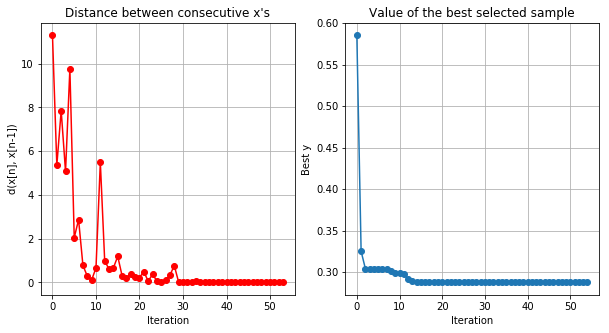

In [ ]:
# it may take a few seconds
opt.run_optimization(max_iter=50)
opt.plot_convergence()

Let's show the best parameters found. They differ significantly from the default parameters.

In [ ]:
x_best = np.exp(opt.X[np.argmin(opt.Y)])
print("The best parameters obtained: C="+str(x_best[0])+", epilson="+str(x_best[1])+", gamma="+str(x_best[2]))
svr = svm.SVR(C=x_best[0], epsilon=x_best[1],gamma=x_best[2])
svr.fit(X_train,Y_train)
Y_train_pred = svr.predict(X_train)
Y_test_pred = svr.predict(X_test)

The best parameters obtained: C=430.280588436, epilson=0.00104925901026, gamma=6.14421235333e-06


We can see SVR does a reasonable fit to the data. The result could be further improved by increasing the *max_iter*. 

RMSE = 0.0709714822355


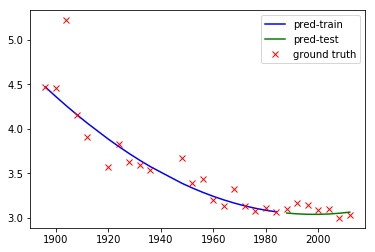

In [ ]:
plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')
plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')
print("RMSE = "+str(np.sqrt(np.square(Y_test_pred-Y_test).mean())))

## Part II: Classification

In the same way as we did for the regression task, we can tune the parameters for a classification problem. The function to optimise is treated as a black box, so the procedure is very similar.

We can start by loading the standard Iris dataset from scikit-learn.

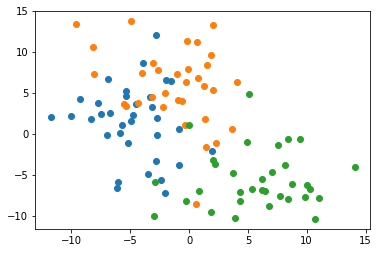

In [11]:
from sklearn.datasets import load_iris, make_blobs

# iris = load_iris()

# # Take the first two features. We could avoid this by using a two-dim dataset
# X = iris.data[:, :2]
# y = iris.target

X, y = make_blobs(centers=3, cluster_std=4, random_state=1234)

for i in np.unique(y):
    idx = y == i
    plt.plot(X[idx,0], X[idx,1], 'o')
# plt.title("First two dimensions of Iris data")
# plt.xlabel('Sepal length')
# plt.ylabel('Sepal width');

Then, let's divide the dataset into a "learning" and a "test" set. The test set will be used later, in order to assess the performance of parameters selected by GPyOpt in relation to [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and a SVC with the default parameters.

For each case, we consider an SVM with RBF kernel.

Let's plot both the learning (with colors related to their classes) and the test data (red "x").

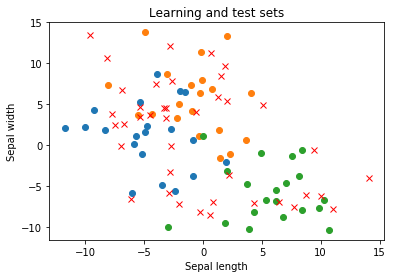

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
train_index, test_index = next(StratifiedShuffleSplit(test_size=.4, random_state=123).split(X,y))

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

for i in np.unique(y_train):
    idx = y_train == i
    plt.plot(X_train[idx,0], X_train[idx,1], 'o')

plt.plot(X_test[:,0], X_test[:,1], 'rx');
plt.title("Learning and test sets")
plt.xlabel('Sepal length')
plt.ylabel('Sepal width');

### 2.1 SVC with no parameter search

The first tentative is to use the SVC with the default parameters.

In [13]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf').fit(X_train, y_train)

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print("SVC with default parameters\nTest score: %.3f" % svc.score(X_test, y_test))

SVC with default parameters
Test score: 0.700


In [14]:
# utility functions taken from
# http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

We can visualise the surfaces defined by the SVM to differentiate the classes. The points have the color of each own class.

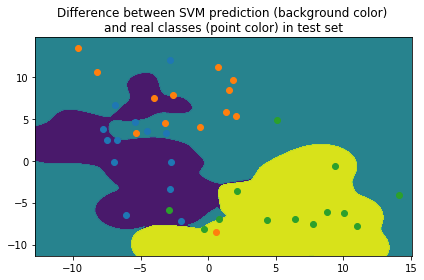

In [15]:
f, ax = plt.subplots(1,1, squeeze=False)
    
for i in np.unique(y_test):
    plot_contours(ax[0,0], svc, xx, yy, alpha=0.8)
    idx = y_test == i
    ax[0,0].plot(X_test[idx,0], X_test[idx,1], 'o')
    ax[0,0].set_title("Difference between SVM prediction (background color) \nand real classes (point color) in test set")
#     ax[0,0].set_xlim([4,8])
#     ax[0,0].set_ylim([2,4.5])
    
# plt.xlabel('Sepal length')
# plt.ylabel('Sepal width');
plt.tight_layout()

### 2.2 GridSearchCV

For comparison, we can use the standard [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for the parameter selection. This will build a grid with the combination of all of the parameters, and then select the best combination of parameters that achieve the maximum validation score (or minimum error).

In [16]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(kernel='rbf'), dict(C=np.logspace(-2,4,10), gamma=np.logspace(-12,-2,10))).fit(X_train,y_train)


print("GridSearchCV\nTest score: %.3f" % grid.score(X_test, y_test))

print("Best parameters extracted: %s" % grid.best_params_)

GridSearchCV
Test score: 0.850
Best parameters extracted: {'C': 0.21544346900318834, 'gamma': 0.01}


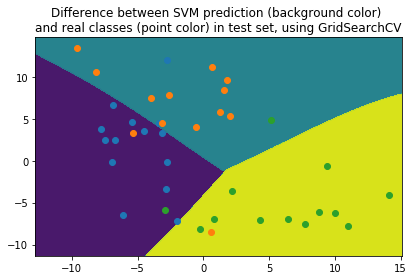

In [17]:
# y_test_pred = grid.predict(X_test)

f, ax = plt.subplots(1,1, squeeze=False)
    
for i in np.unique(y_test):
    plot_contours(ax[0,0], grid, xx, yy, alpha=0.8)
    idx = y_test == i
    ax[0,0].plot(X_test[idx,0], X_test[idx,1], 'o')
    ax[0,0].set_title("Difference between SVM prediction (background color) \n"
                      "and real classes (point color) in test set, using GridSearchCV")
#     ax[0,0].set_xlim([4,8])
#     ax[0,0].set_ylim([2,4.5])
    
# plt.xlabel('Sepal length')
# plt.ylabel('Sepal width');
plt.tight_layout()

### 2.3 GPy optimization

In [18]:
domain       =[{'name': 'C',      'type': 'continuous', 'domain': (-2.,4.)},
#                {'name': 'kernel', 'type': 'categorical', 'domain': (0, 1)},
               {'name': 'gamma',  'type': 'continuous', 'domain': (-12.,-2.)}
              ]

In [19]:
from sklearn.model_selection import cross_val_score
    
def fit_svc_val(x, mdl=None, cv=None):
    x = np.atleast_2d(np.exp(x))
    fs = np.zeros((x.shape[0], 1))
    for i, params in enumerate(x):
        dict_params = dict(zip([el['name'] for el in domain], params))
        if 'kernel' in dict_params:
            dict_params['kernel'] = 'rbf' if dict_params['kernel'] == 0 else 'poly'
        mdl.set_params(**dict_params)
        fs[i] = -np.mean(cross_val_score(mdl, X_train, y_train, cv=cv))
    return fs

The set cost function is ignored! LBC acquisition does not make sense with cost.


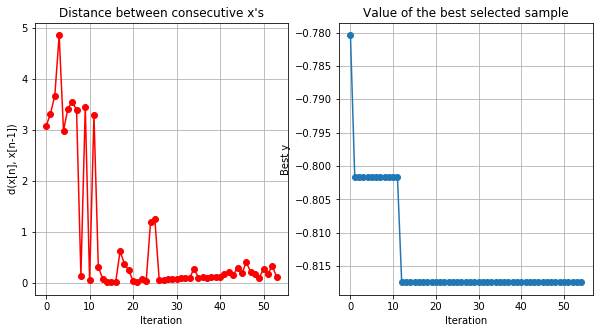

In [24]:
from functools import partial
opt = GPyOpt.methods.BayesianOptimization(f = partial(fit_svc_val, mdl=SVC(kernel='rbf')),  # function to optimize       
                                          domain = domain,         # box-constrains of the problem
                                          acquisition_type ='LCB',       # LCB acquisition
                                          acquisition_weight = 0.2)   # Exploration exploitation
opt.run_optimization(max_iter=50)
opt.plot_convergence()

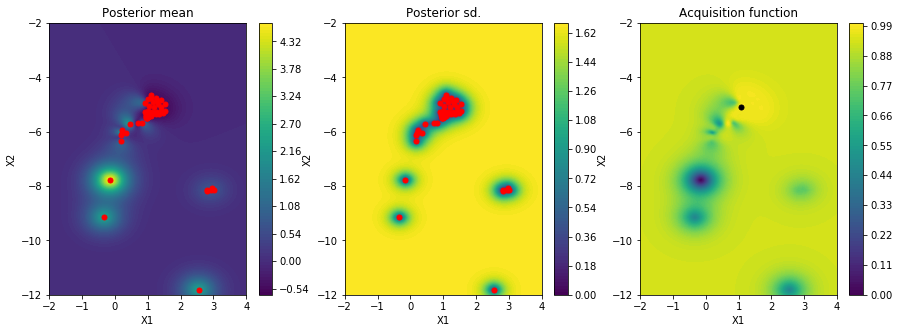

In [25]:
opt.plot_acquisition()

In [26]:
x_best = np.exp(opt.X[np.argmin(opt.Y)])
best_params = dict(zip([el['name'] for el in domain], x_best))

svc_opt = SVC(**best_params)
svc_opt.fit(X_train, y_train)
# y_train_pred = svc.predict(X_train)
# y_test_pred = svc.predict(X_test)


print("GPyOpt\nTest score: %.3f" % svc_opt.score(X_test, y_test))

print("Best parameters extracted: %s" % best_params)

GPyOpt
Test score: 0.850
Best parameters extracted: {'C': 2.03757065667337, 'gamma': 0.0033852993544374603}


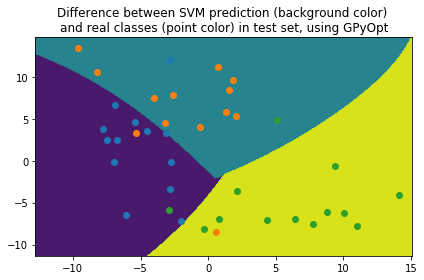

In [27]:
# y_test_pred = grid.predict(X_test)

f, ax = plt.subplots(1,1, squeeze=False)
    
for i in np.unique(y_test):
    plot_contours(ax[0,0], svc_opt, xx, yy, alpha=0.8)
    idx = y_test == i
    ax[0,0].plot(X_test[idx,0], X_test[idx,1], 'o')
    ax[0,0].set_title("Difference between SVM prediction (background color) \n"
                      "and real classes (point color) in test set, using GPyOpt")
#     ax[0,0].set_xlim([4,8])
#     ax[0,0].set_ylim([2,4.5])
    
# plt.xlabel('Sepal length')
# plt.ylabel('Sepal width');
plt.tight_layout()

The parameter selected by GridSearchCV and GPyOpt are very similar. However, it is clear from the convergence plots that GPyOpt converges very quickly to the minimum, while GridSearch has to test each combination of parameters.